In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split
import xgboost as xgb
from sklearn.metrics import roc_auc_score
import joblib
import pandas as pd
import numpy as np
import xgboost as xgb
import shap
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score
from sklearn.decomposition import PCA


In [2]:

# Load datasets
# df1 = pd.read_parquet('/kaggle/input/dataset/add_event.parquet')
# df2 = pd.read_parquet('/kaggle/input/dataset/add_trans.parquet')
# df3 = pd.read_parquet('/kaggle/input/dataset/offer_metadata.parquet')
df4 = pd.read_parquet('/kaggle/input/dataset/train_data.parquet')
df5 = pd.read_parquet('/kaggle/input/dataset/test_data.parquet')
df6 = pd.read_csv('/kaggle/input/dataset/685404e30cfdb_submission_template.csv')

In [3]:
def basic_preprocessing(df):
    for c in df.columns:
        df[c] = pd.to_numeric(df[c], errors='coerce')
    df.fillna(0, inplace=True)
    df.replace([np.inf, -np.inf], 0, inplace=True)
    return df

train_df = basic_preprocessing(df4.copy())
test_df  = basic_preprocessing(df5.copy())


In [4]:
# --- 2. Drop IDs + Extract Target ---
ids = ['id1','id2','id3','id4','id5']
y   = train_df['y'].astype(int)
train_df.drop(columns='y', inplace=True)

In [5]:
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans

def add_features(df):
    # binning top features
    df['f363_bin'] = pd.cut(df['f363'], [-np.inf, 0.1, 0.25, np.inf], labels=[0, 1, 2]).astype(int)
    df['f366_bin'] = pd.cut(df['f366'], [-np.inf, 0.1, 0.3, np.inf], labels=[0, 1, 2]).astype(int)

    # interactions
    df['f363_x_f331'] = df['f363'] * df['f331']
    df['f366_x_f329'] = df['f366'] * df['f329']
    df['f150_x_f329'] = df['f150'] * df['f329']
    df['f138_x_f22']  = df['f138'] * df['f22']
    df['f132_x_f68']  = df['f132'] * df['f68']
    df['f363_x_f366'] = df['f363'] * df['f366']
    df['f363_div_f329'] = df['f363'] / (df['f329'] + 1e-6)
    df['f366_div_f329'] = df['f366'] / (df['f329'] + 1e-6)
    
    # higher-order
    df['f132_sq']   = df['f132']**2
    df['f363_sq']   = df['f363']**2
    df['f366_sq']   = df['f366']**2
    df['f363_log']  = np.log1p(df['f363'].clip(lower=0))
    df['f366_inv']  = 1.0 / (df['f366'] + 1e-6)
    
    # ratio and log transform
    df['f214_to_f22'] = df['f214'] / (df['f22'] + 1e-6)
    df['f351_log']    = np.log1p(df['f351'])
    
    # weekday/weekend + one-hot
    df['is_weekend'] = df['f223'].isin([6,7]).astype(int)
    df = pd.get_dummies(df, columns=['f223'], prefix='weekday', drop_first=True)
    
    # low-importance PCA + stats
    low_imp = ['f319','f324','f329','f325','f120','f121','f122']
    pca = PCA(n_components=1)
    df['lowimp_pca1'] = pca.fit_transform(df[low_imp])
    df['lowimp_mean'] = df[low_imp].mean(axis=1)
    df['lowimp_std']  = df[low_imp].std(axis=1)

    # missing value flags
    for col in ['f363', 'f366', 'f150', 'f138']:
        df[f'{col}_missing'] = df[col].isna().astype(int)
    
    # clustering (with explicit n_init to suppress warning)
    cluster = KMeans(n_clusters=3, random_state=42, n_init=10)
    df['f363_f366_cluster'] = cluster.fit_predict(df[['f363', 'f366']])
    
    # cross-bin combination
    df['f363_f366_bin'] = (df['f363_bin'].astype(str) + "_" + df['f366_bin'].astype(str)).astype('category').cat.codes
    
    # convert any residual categories
    for col in df.select_dtypes(include=['category']).columns:
        df[col] = df[col].cat.codes
        
    return df


In [6]:
# --- 4. Drop Original IDs + Low‑Variance Features ---
drop_cols = ids.copy()
numeric   = train_df.select_dtypes(include=[np.number])
lowvar    = numeric.std()[numeric.std() < 1e-3].index.tolist()
drop_cols += lowvar

train_df.drop(columns=drop_cols, inplace=True, errors='ignore')
test_df .drop(columns=[c for c in drop_cols if c in test_df.columns], inplace=True, errors='ignore')

In [7]:
# --- 5. Train/Validation Split ---
X_train, X_val, y_train, y_val = train_test_split(
    train_df, y, test_size=0.2, random_state=42
)

# --- 6. First XGBoost Training (binary:logistic) ---
params = {
    'objective': 'binary:logistic',
    'learning_rate': 0.05,
    'max_depth': 8,
    'min_child_weight': 0.1,
    'gamma': 1.0,
    'subsample': 0.8,
    'colsample_bytree': 0.8,
    'eval_metric': 'auc',
    'seed': 42
}


In [8]:
dtrain = xgb.DMatrix(X_train, label=y_train)
dval   = xgb.DMatrix(X_val,   label=y_val)

model1 = xgb.train(
    params,
    dtrain,
    num_boost_round=1500,
    evals=[(dtrain,'train'), (dval,'val')],
    early_stopping_rounds=50,
    verbose_eval=100
)

# Evaluate initial model
y_val_pred1 = model1.predict(dval)
auc1 = roc_auc_score(y_val, y_val_pred1)
print(f"Initial Validation AUC: {auc1:.4f}")

[0]	train-auc:0.89846	val-auc:0.89583
[100]	train-auc:0.96438	val-auc:0.94733
[200]	train-auc:0.97766	val-auc:0.95330
[300]	train-auc:0.98453	val-auc:0.95539
[400]	train-auc:0.98891	val-auc:0.95626
[500]	train-auc:0.99244	val-auc:0.95669
[600]	train-auc:0.99469	val-auc:0.95692
[655]	train-auc:0.99562	val-auc:0.95681
Initial Validation AUC: 0.9568


In [9]:
# --- 7. SHAP on Sample & Percentile Feature Selection ---
sample = X_train.sample(min(500, len(X_train)), random_state=42)
explainer = shap.TreeExplainer(model1)
shap_vals = explainer.shap_values(sample)

# Compute mean |SHAP| per feature across the sample
mean_abs_shap = np.abs(shap_vals).mean(axis=0)
feat_imp = pd.Series(mean_abs_shap, index=sample.columns)

# Drop bottom 25% of features by importance
cutoff = feat_imp.quantile(0.01)
keep_feats = feat_imp[feat_imp >= cutoff].index.tolist()
print(f"Keeping {len(keep_feats)} of {X_train.shape[1]} features (cutoff={cutoff:.4e})")

Keeping 294 of 294 features (cutoff=0.0000e+00)


In [10]:
# --- 8. Retrain XGBoost on Selected Features ---
# Subset train and validation sets
X_train_sel = X_train[keep_feats]
X_val_sel   = X_val[keep_feats]

# Ensure all SHAP-selected features are in test_df
missing_feats = [col for col in keep_feats if col not in test_df.columns]
if missing_feats:
    print(f"Adding {len(missing_feats)} missing features to test_df: {missing_feats}")
    for col in missing_feats:
        test_df[col] = 0

# Now subset test set
test_sel = test_df[keep_feats]
dtrain2 = xgb.DMatrix(X_train_sel, label=y_train)
dval2   = xgb.DMatrix(X_val_sel,   label=y_val)

model2 = xgb.train(
    params,
    dtrain2,
    num_boost_round=1500,
    evals=[(dtrain2,'train2'), (dval2,'val2')],
    early_stopping_rounds=50,
    verbose_eval=100
)

[0]	train2-auc:0.89846	val2-auc:0.89583
[100]	train2-auc:0.96438	val2-auc:0.94733
[200]	train2-auc:0.97766	val2-auc:0.95330
[300]	train2-auc:0.98453	val2-auc:0.95539
[400]	train2-auc:0.98891	val2-auc:0.95626
[500]	train2-auc:0.99244	val2-auc:0.95669
[600]	train2-auc:0.99469	val2-auc:0.95692
[654]	train2-auc:0.99561	val2-auc:0.95680


Filtered Validation AUC: 0.9568


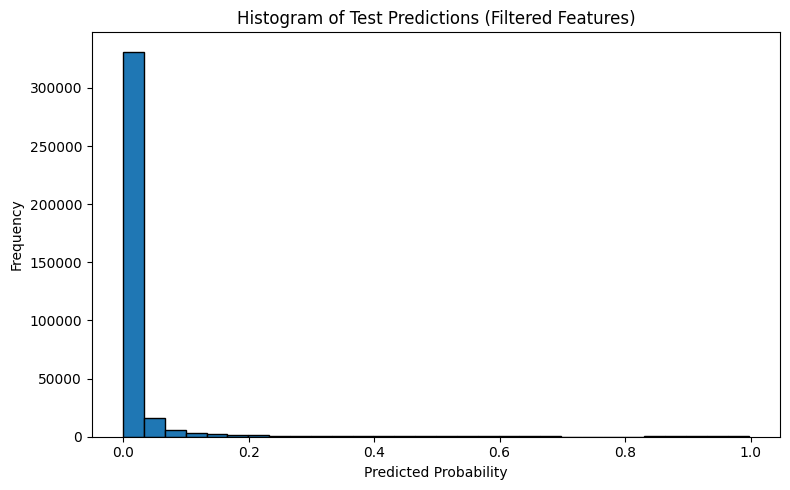

In [11]:
# Evaluate filtered model
y_val_pred2 = model2.predict(dval2)
auc2 = roc_auc_score(y_val, y_val_pred2)
print(f"Filtered Validation AUC: {auc2:.4f}")

# --- 9. Histogram of Test Predictions (Probabilities) from filtered model ---
dtest2 = xgb.DMatrix(test_sel)
test_scores2 = model2.predict(dtest2)

plt.figure(figsize=(8,5))
plt.hist(test_scores2, bins=30, edgecolor='k')
plt.title("Histogram of Test Predictions (Filtered Features)")
plt.xlabel("Predicted Probability")
plt.ylabel("Frequency")
plt.tight_layout()
plt.savefig("hist_predictions_filtered.png")
plt.show()

In [12]:
# --- 10. Save Filtered Predictions CSV ---
output = pd.DataFrame({
    'id1': df5['id1'],
    'id2': df5['id2'],
    'id3': df5['id3'],
    'id5': df5['id5'],
    'pred': test_scores2
})
output.to_csv("predictions_filtered.csv", index=False)

print("Done. Outputs:")
print(" • predictions_filtered.csv")
print(" • hist_predictions_filtered.png")

Done. Outputs:
 • predictions_filtered.csv
 • hist_predictions_filtered.png


In [13]:
# --- 10. Robustly populate template y from predictions ---
sub_df = pd.read_csv('/kaggle/input/dataset/685404e30cfdb_submission_template.csv')

# Build a lookup dict from id1 → probability
pred_map = dict(zip(df5['id1'], test_scores2))

# Map into the template, fill missing with 0.5, clip to [0,1]
sub_df['y'] = sub_df['id1'].map(pred_map).fillna(0.5).clip(0, 1)

# Ensure we only have the template's original columns (including y)
final = sub_df[sub_df.columns]  # same as sub_df, but explicit

# Write out
final.to_csv('final_submission.csv', index=False)
print("Wrote final_submission.csv successfully!")


Wrote final_submission.csv successfully!


In [14]:
len(final)

369301

In [15]:
final['id1']==sub_df['id1']

0         True
1         True
2         True
3         True
4         True
          ... 
369296    True
369297    True
369298    True
369299    True
369300    True
Name: id1, Length: 369301, dtype: bool

In [16]:
(final['pred']<0).sum()

invalid value encountered in less


0